In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy import ceil
import scipy

In [3]:
source_path = '/content/drive/MyDrive/Data'


list=[]

for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))

            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 1306 images of Calculus.

Convert Successful
Converted image = 0
There are 2382 images of Data caries.

Convert Successful
Converted image = 0
There are 183 images of Tooth Discoloration.

Convert Successful
Converted image = 0
There are 1251 images of hypodontia.

Convert Successful
Converted image = 0
There are 82 images of normal.

Convert Successful
Converted image = 0
There are 2541 images of Mouth Ulcer.

Convert Successful
Converted image = 0
There are 2349 images of Gingivitis.



In [4]:
root_dir = 'Data'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:

    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR

In [6]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

split_size = .8

for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")

Split Calculus Successful
There are 1044 images of Calculus for training.
There are 262 images of Calculus for validation.

Split Data caries Successful
There are 1905 images of Data caries for training.
There are 477 images of Data caries for validation.

Split Tooth Discoloration Successful
There are 146 images of Tooth Discoloration for training.
There are 37 images of Tooth Discoloration for validation.

Split hypodontia Successful
There are 1000 images of hypodontia for training.
There are 251 images of hypodontia for validation.

Split normal Successful
There are 65 images of normal for training.
There are 17 images of normal for validation.

Split Mouth Ulcer Successful
There are 2032 images of Mouth Ulcer for training.
There are 509 images of Mouth Ulcer for validation.

Split Gingivitis Successful
There are 1879 images of Gingivitis for training.
There are 470 images of Gingivitis for validation.



In [7]:
TRAINING_DIR = "/content/Data/train"
TESTING_DIR = "/content/Data/validation"
#train_val_generators
def train_val_generators(TRAINING_DIR, TESTING_DIR):

  train_data = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_data.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(299,299))

  # Rescaling Image
  testing_data = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  testing_generator = testing_data.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299,299))
  ### END CODE HERE
  return train_generator, testing_generator

In [8]:
train_generator, testing_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 8071 images belonging to 7 classes.
Found 2023 images belonging to 7 classes.


In [10]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling = 'avg')

  # Flatten
x = base_model.output
  # Add Full connected layer
x = Dense(32, activation='relu')(x)
  # Adding dropout layer to prevent overfit
x = Dropout(rate=.5)(x)
  # ouput layer for 4 categories that we train
predictions = Dense(7, activation='softmax')(x)

  # Training Model
model = Model(inputs=base_model.input, outputs=predictions)

#freeze all trainable layer
for layer in base_model.layers:
  layer.trainable = False

#Compile the model
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
              metrics=['accuracy'])

#unfreeze several layer from trainable layer
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

model.summary();
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=testing_generator)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

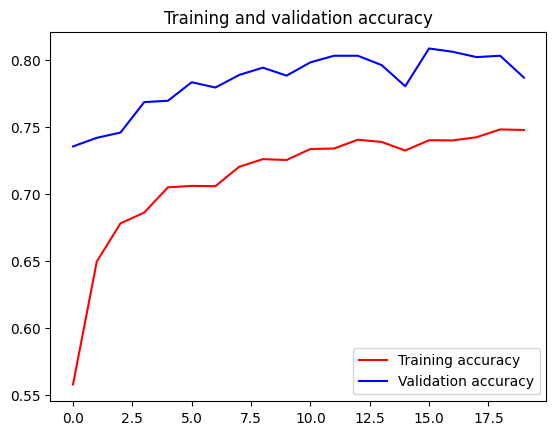

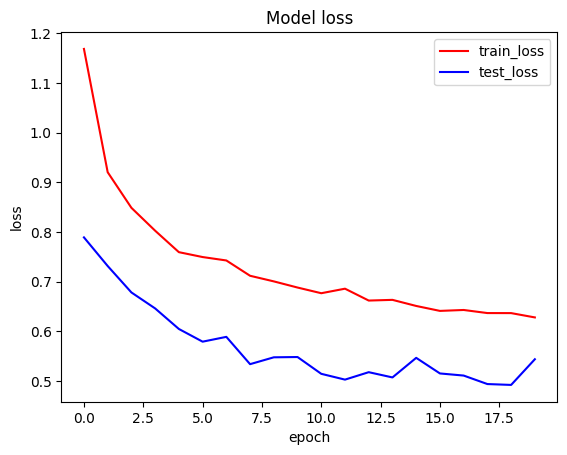

In [11]:
def plot_train_history(history):
    # Summarize history for accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs,loss, 'r', label='train_loss')
    plt.plot(epochs,val_loss, 'b', label='test_loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc=0)
    plt.show()


plot_train_history(history)

In [14]:
model.save('modeldentiva.h5')

1/1 [==============================] - 0s 58ms/step


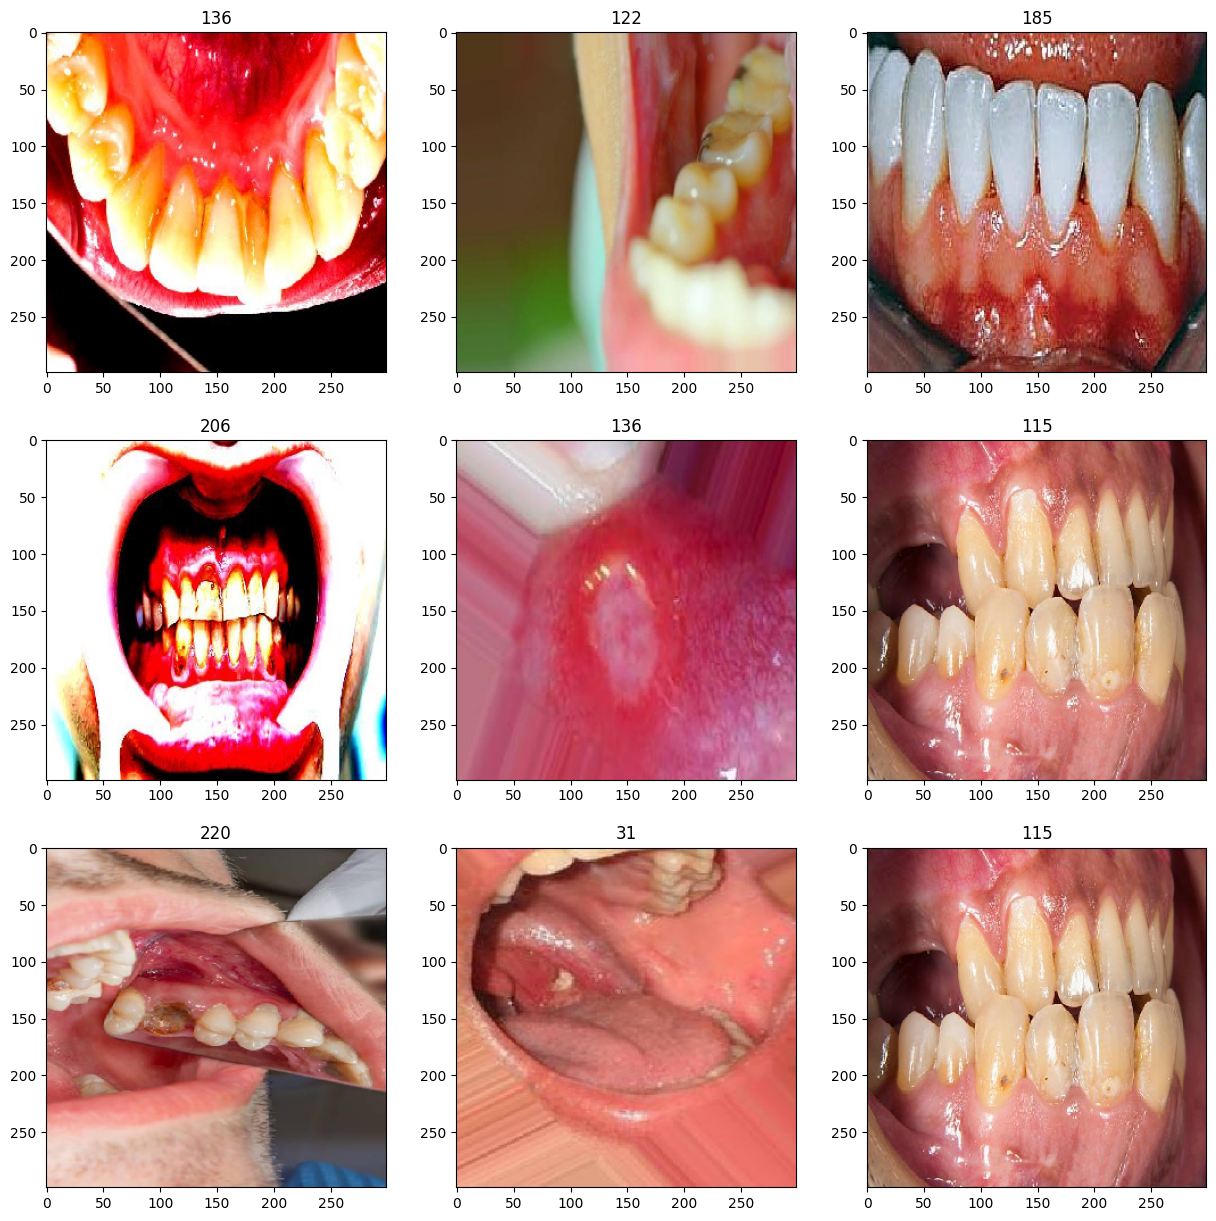

In [15]:
import numpy as np
label_names = {0: 'Calculus', 1: 'Data caries', 2: 'Gintivitis', 3: 'Mouth Ulcer', 4:'Tooth Discoloration', 5: 'hypodontia', 6: 'normal'}
def run_prediction():
     n = 331
     plt.figure(figsize=(15, 15))
     for i in range(9):
         plt.subplot(n)
         idx = random.randint(0, len(testing_generator)-1)
         predict = model.predict(testing_generator[idx][0])
         plt.imshow(testing_generator[idx][0][0])
         plt.title(np.argmax(predict))
         n += 1
run_prediction()

In [16]:
from keras.models import load_model

# load model
model = load_model('modeldentiva.h5')

In [17]:
# new_model= tf.keras.models.load_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with open("model_tflite.tflite", 'wb') as f:
  f.write(tflite_model)
  print("Saved model to disk")

Saved model to disk


1/1 [==============================] - 2s 2s/step
Prediction for /content/drive/MyDrive/Data/Calculus/(1).jpeg: Gintivitis
Confidence: 0.7940833



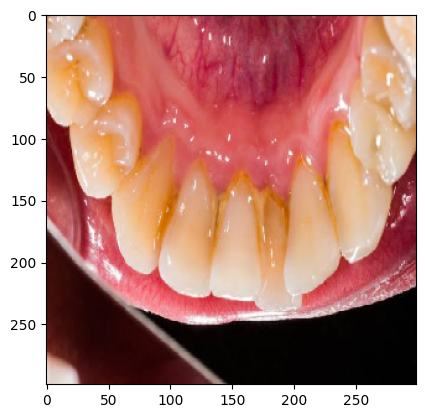

1/1 [==============================] - 0s 24ms/step
Prediction for /content/drive/MyDrive/Data/Calculus/(10).jpeg: Gintivitis
Confidence: 0.6976876



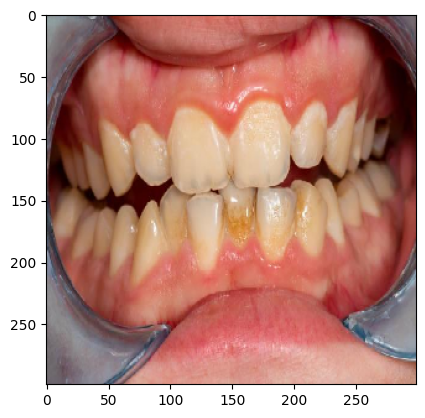

1/1 [==============================] - 0s 35ms/step
Prediction for /content/drive/MyDrive/Data/Calculus/(100).jpeg: Gintivitis
Confidence: 0.69209456



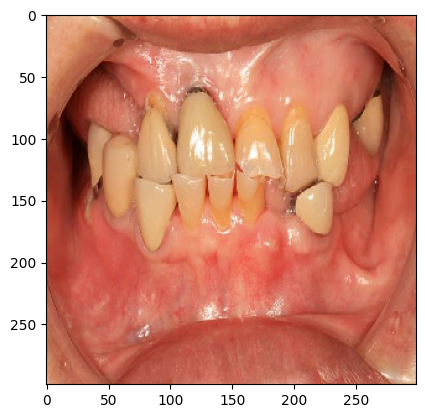

1/1 [==============================] - 0s 50ms/step
Prediction for /content/drive/MyDrive/Data/Calculus/(1000).jpeg: Gintivitis
Confidence: 0.7527409



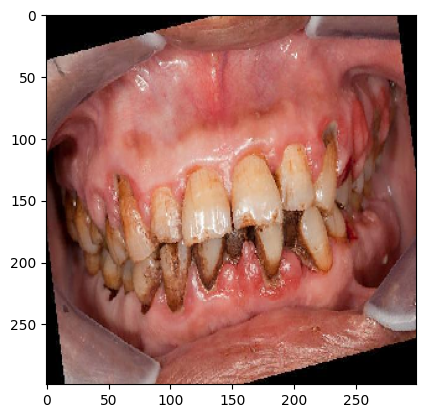

1/1 [==============================] - 0s 49ms/step
Prediction for /content/drive/MyDrive/Data/Data caries/(1).jpeg: Data caries
Confidence: 0.5773614



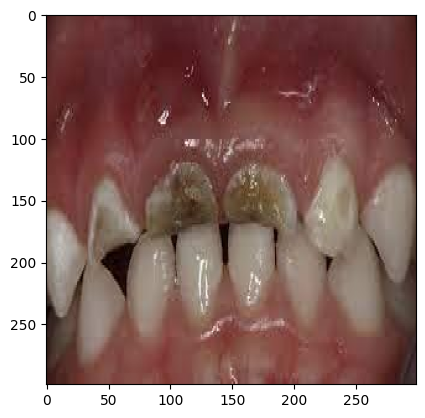

1/1 [==============================] - 0s 38ms/step
Prediction for /content/drive/MyDrive/Data/Data caries/(10).jpeg: Gintivitis
Confidence: 0.64067787



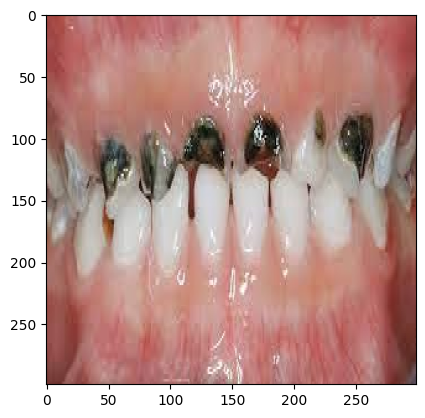

1/1 [==============================] - 0s 34ms/step
Prediction for /content/drive/MyDrive/Data/Data caries/(100).jpeg: Gintivitis
Confidence: 0.7514958



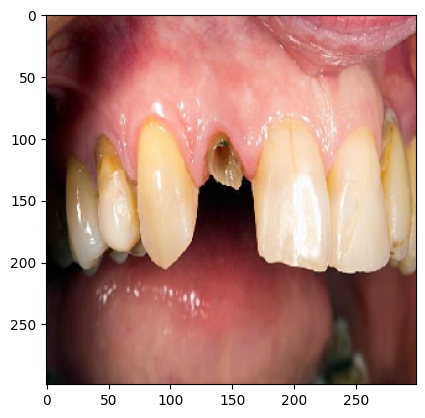

1/1 [==============================] - 0s 36ms/step
Prediction for /content/drive/MyDrive/Data/Data caries/(1000).jpeg: Data caries
Confidence: 0.4845511



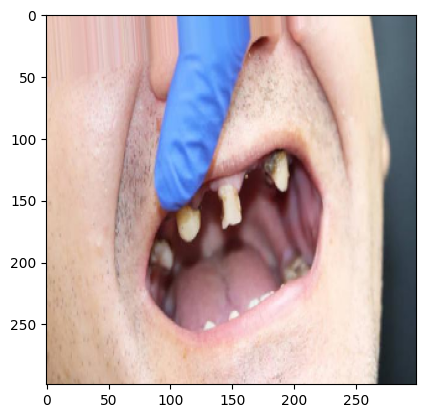

1/1 [==============================] - 0s 45ms/step
Prediction for /content/drive/MyDrive/Data/Gingivitis/(1).jpeg: Gintivitis
Confidence: 0.9184911



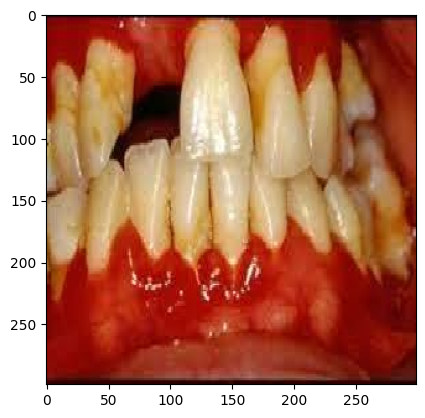

1/1 [==============================] - 0s 60ms/step
Prediction for /content/drive/MyDrive/Data/Gingivitis/(10).jpeg: Gintivitis
Confidence: 0.89794743



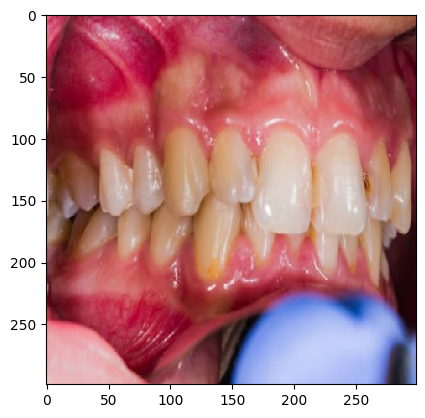

1/1 [==============================] - 0s 54ms/step
Prediction for /content/drive/MyDrive/Data/Gingivitis/(100).jpeg: Gintivitis
Confidence: 0.79705155



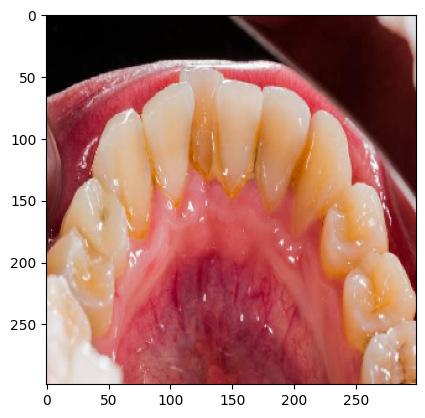

1/1 [==============================] - 0s 45ms/step
Prediction for /content/drive/MyDrive/Data/Gingivitis/(1000).JPG: hypodontia
Confidence: 0.6568952



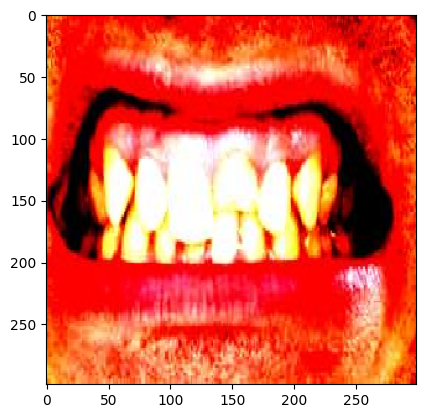

1/1 [==============================] - 0s 23ms/step
Prediction for /content/drive/MyDrive/Data/Mouth Ulcer/(1).jpeg: Calculus
Confidence: 0.58216953



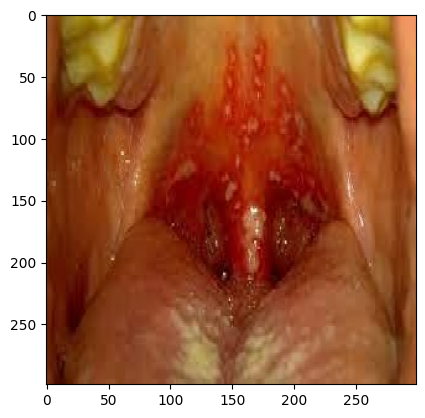

1/1 [==============================] - 0s 24ms/step
Prediction for /content/drive/MyDrive/Data/Mouth Ulcer/(10).jpeg: Mouth Ulcer
Confidence: 0.33482954



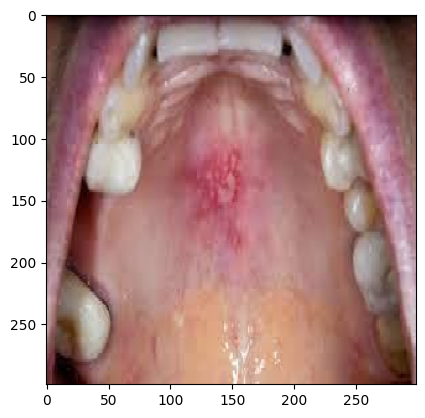

1/1 [==============================] - 0s 25ms/step
Prediction for /content/drive/MyDrive/Data/Mouth Ulcer/(100).jpeg: Mouth Ulcer
Confidence: 0.9580493



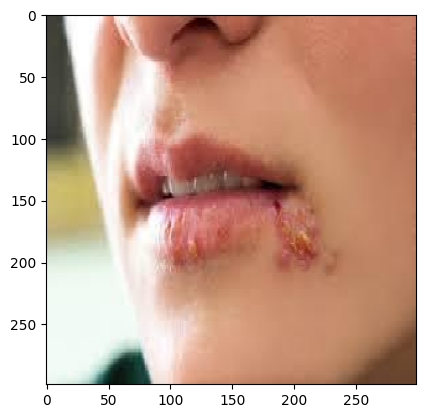

1/1 [==============================] - 0s 24ms/step
Prediction for /content/drive/MyDrive/Data/Mouth Ulcer/(1000).jpeg: Mouth Ulcer
Confidence: 0.9015097



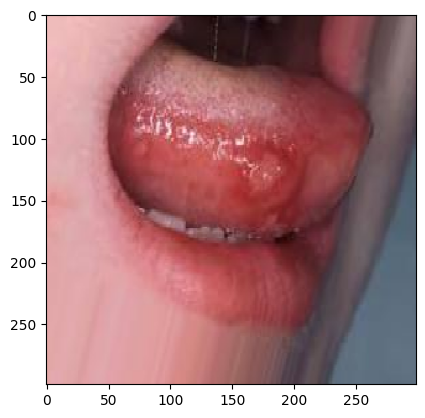

1/1 [==============================] - 0s 24ms/step
Prediction for /content/drive/MyDrive/Data/Tooth Discoloration/1.jpeg: Gintivitis
Confidence: 0.64232



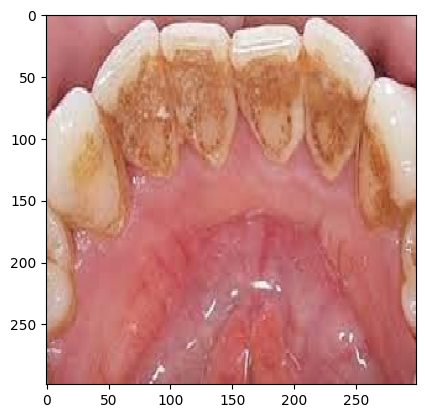

1/1 [==============================] - 0s 29ms/step
Prediction for /content/drive/MyDrive/Data/Tooth Discoloration/10.jpeg: Data caries
Confidence: 0.6468565



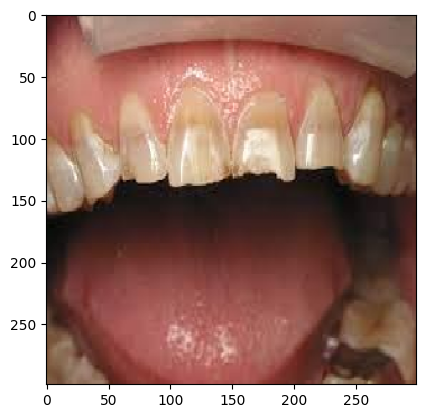

1/1 [==============================] - 0s 27ms/step
Prediction for /content/drive/MyDrive/Data/Tooth Discoloration/100.jpeg: Calculus
Confidence: 0.40300134



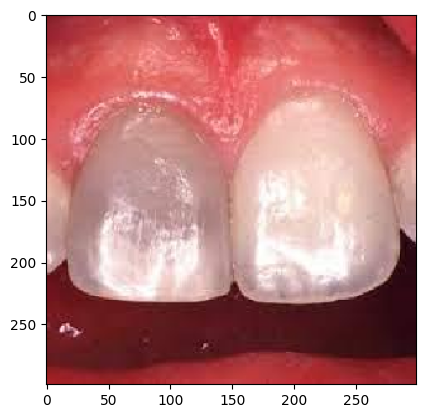

1/1 [==============================] - 0s 33ms/step
Prediction for /content/drive/MyDrive/Data/Tooth Discoloration/101.jpeg: Data caries
Confidence: 0.684143



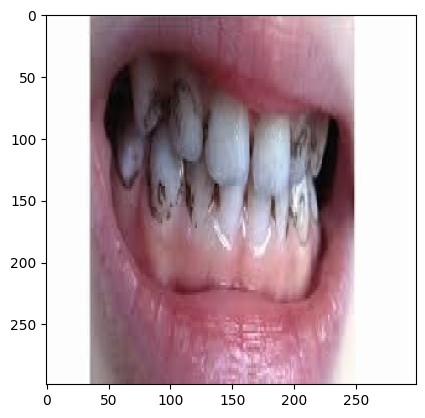

1/1 [==============================] - 0s 23ms/step
Prediction for /content/drive/MyDrive/Data/hypodontia/(1).JPG: hypodontia
Confidence: 0.9659589



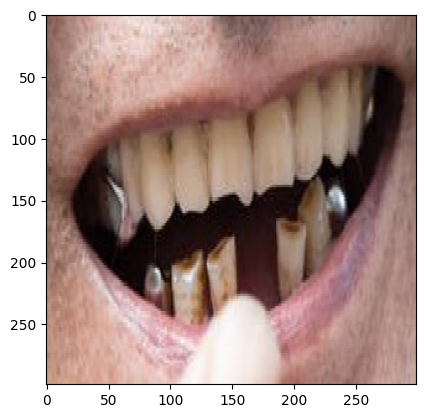

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Data/hypodontia/(10).JPG: hypodontia
Confidence: 0.99973375



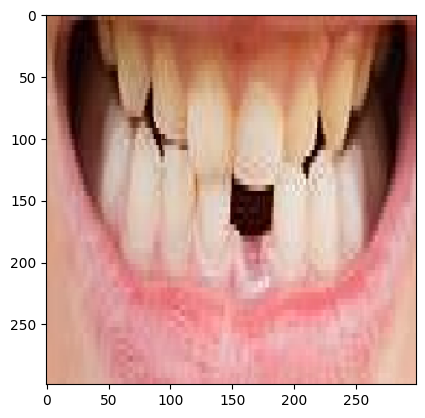

1/1 [==============================] - 0s 35ms/step
Prediction for /content/drive/MyDrive/Data/hypodontia/(100).JPG: hypodontia
Confidence: 0.96149087



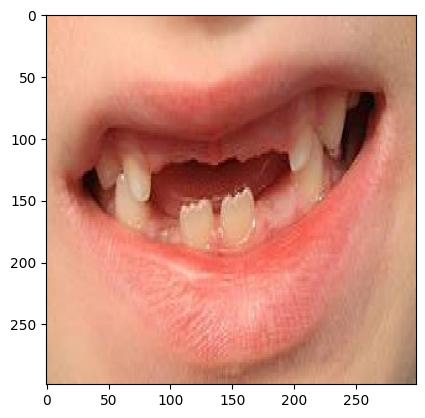

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Data/hypodontia/(1000).JPG: hypodontia
Confidence: 0.85957783



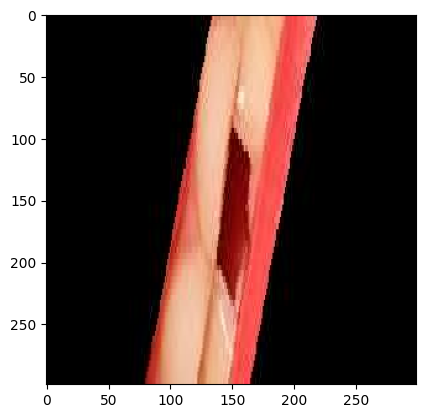

1/1 [==============================] - 0s 26ms/step
Prediction for /content/drive/MyDrive/Data/normal/ (1).jpeg: Gintivitis
Confidence: 0.69522446



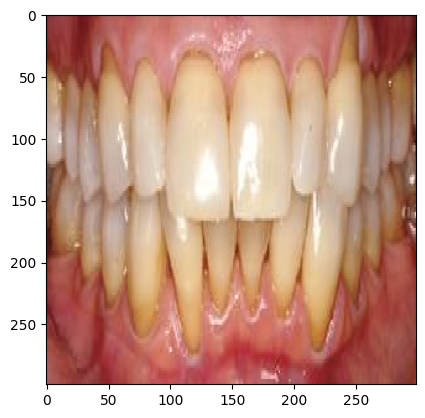

1/1 [==============================] - 0s 33ms/step
Prediction for /content/drive/MyDrive/Data/normal/ (10).jpeg: Gintivitis
Confidence: 0.47588718



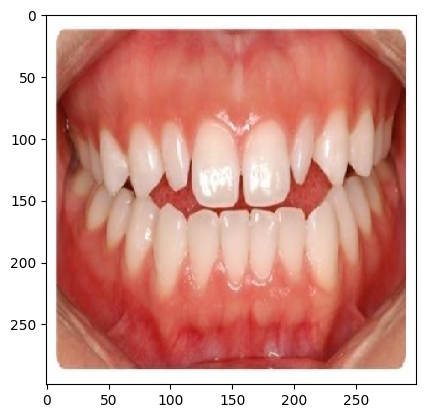

1/1 [==============================] - 0s 34ms/step
Prediction for /content/drive/MyDrive/Data/normal/ (11).jpeg: Gintivitis
Confidence: 0.38538957



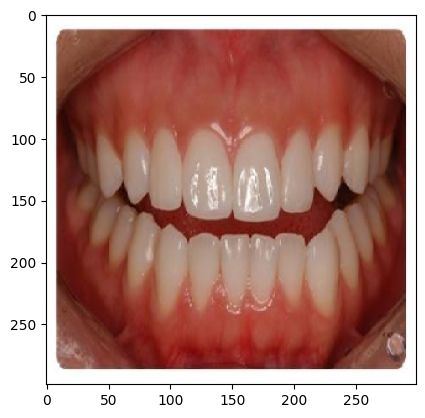

1/1 [==============================] - 0s 35ms/step
Prediction for /content/drive/MyDrive/Data/normal/ (12).jpeg: Gintivitis
Confidence: 0.6082837



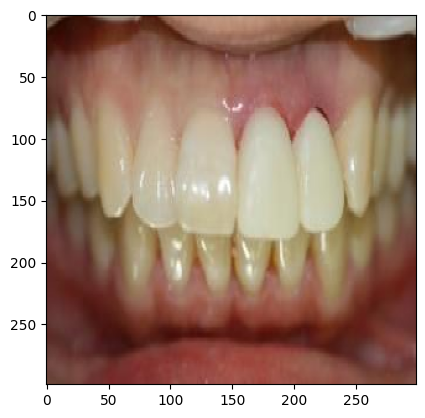

In [18]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt


file_paths = [
    '/content/drive/MyDrive/Data/Calculus/(1).jpeg',
    '/content/drive/MyDrive/Data/Calculus/(10).jpeg',
    '/content/drive/MyDrive/Data/Calculus/(100).jpeg',
    '/content/drive/MyDrive/Data/Calculus/(1000).jpeg',
    '/content/drive/MyDrive/Data/Data caries/(1).jpeg',
    '/content/drive/MyDrive/Data/Data caries/(10).jpeg',
    '/content/drive/MyDrive/Data/Data caries/(100).jpeg',
    '/content/drive/MyDrive/Data/Data caries/(1000).jpeg',
    '/content/drive/MyDrive/Data/Gingivitis/(1).jpeg',
    '/content/drive/MyDrive/Data/Gingivitis/(10).jpeg',
    '/content/drive/MyDrive/Data/Gingivitis/(100).jpeg',
    '/content/drive/MyDrive/Data/Gingivitis/(1000).JPG',
    '/content/drive/MyDrive/Data/Mouth Ulcer/(1).jpeg',
    '/content/drive/MyDrive/Data/Mouth Ulcer/(10).jpeg',
    '/content/drive/MyDrive/Data/Mouth Ulcer/(100).jpeg',
    '/content/drive/MyDrive/Data/Mouth Ulcer/(1000).jpeg',
    '/content/drive/MyDrive/Data/Tooth Discoloration/1.jpeg',
    '/content/drive/MyDrive/Data/Tooth Discoloration/10.jpeg',
    '/content/drive/MyDrive/Data/Tooth Discoloration/100.jpeg',
    '/content/drive/MyDrive/Data/Tooth Discoloration/101.jpeg',
    '/content/drive/MyDrive/Data/hypodontia/(1).JPG',
    '/content/drive/MyDrive/Data/hypodontia/(10).JPG',
    '/content/drive/MyDrive/Data/hypodontia/(100).JPG',
    '/content/drive/MyDrive/Data/hypodontia/(1000).JPG',
    '/content/drive/MyDrive/Data/normal/ (1).jpeg',
    '/content/drive/MyDrive/Data/normal/ (10).jpeg',
    '/content/drive/MyDrive/Data/normal/ (11).jpeg',
    '/content/drive/MyDrive/Data/normal/ (12).jpeg'
    # Add paths for the remaining 18 photos
    # ...
]
for path in file_paths:
    # Load image and resize
    img = image.load_img(path, target_size=(299, 299))
    # Convert image to array and rescale
    x = image.img_to_array(img) / 255
    # Change shape of the image
    x = np.expand_dims(x, axis=0)

    # Make predictions
    classes = model.predict(x, batch_size=10)

    # Get the predicted class name
    label_names = {0: 'Calculus', 1: 'Data caries', 2: 'Gintivitis', 3: 'Mouth Ulcer', 4:'Tooth Discoloration', 5: 'hypodontia', 6: 'normal'}
    prediction_name = label_names[np.argmax(classes[0])]

    # Get the confidence percentage
    confidence_percentage = str(np.max(classes))

    # Print the results for each image
    print(f"Prediction for {path}: {prediction_name}")
    print(f"Confidence: {confidence_percentage}\n")

    # Optionally, display the image
    plt.imshow(img)
    plt.show()